# Analysis Iteration 

Here, we demonstrate how we can use extracted OCEL as a tester to validate if the questions can be answered based on the test data. Please note that we have verified the correctness of the extracted log with the help of verification metrics as well as state chart diagram in Pm4Moodle. 

Here are the list of questions: 
* Q1: What learning paths do students typically follow when accessing educational materials, such as files, pages, and folders, throughout a course?
* Q2: How do students submit (or resubmit) individual and group assignments during the course?
* Q3: Do students who usually take the lead in submitting group assignments on behalf of the group tend to achieve higher final grades?
* Q4: How is students' exam success related to their frequency of accessing course materials, such as files, pages, and folders?
* Q5: How can OCEL 2.0 event logs be systematically extracted for Moodle’s most important standard modules?

We need to install processmining library as well that enables applications of OLAP operations. This library install PM4Py by default. 

In [1]:
%%capture
! pip install processmining

In [2]:
import pandas as pd
import pm4py
import processmining.log.ocel as ocelhelper

In [3]:
filename = './ocel2.0.json'
ocel = pm4py.read_ocel2_json(filename)
ocel

c:\workspace\PM4Moodle\.venv\Lib\site-packages\pm4py\utils.py:991: UserWarning: Install the optional requirement `rustxes` to import/export files faster.
  warnings.warn("Install the optional requirement `rustxes` to import/export files faster.")


Object-Centric Event Log (number of events: 531, number of objects: 179, number of activities: 71, number of object types: 19, events-objects relationships: 1846)
Activities occurrences: Counter({'view_assign': 56, 'view_forum': 38, 'view_choice': 30, 'view_quiz': 25, 'set_grade': 17, 'view_folder': 15, 'view_discussion': 14, 'create_question': 12, 'update_grade': 11, 'add_question_to_quiz': 9, 'delete_choice': 9, 'make_a_choice': 9, 'delete_forum': 9, 'import_forum': 9, 'delete_folder': 8, 'import_choice': 8, 'delete_assign': 8, 'update_assign': 7, 'import_assign': 7, 'view_file': 7, 'view_page': 7, 'import_quiz': 7, 'update_forum': 7, 'delete_quiz': 6, 'delete_question_from_quiz': 6, 'create_assign': 6, 'subscribe_to_discussion': 6, 'delete_url': 6, 'update_page': 6, 'update_quiz': 6, 'delete_question': 6, 'download_folder': 6, 'subscribe_to_forum': 6, 'delete_page': 6, 'delete_file': 6, 'view_url': 6, 'update_file': 5, 'upload_post': 5, 'update_url': 5, 'update_folder': 5, 'create_f

In [4]:
# selecting the course id for the course "Digital Transformation in Organizations"
# This is the course we are interested in for the analysis
course_id = ocel.objects[(ocel.objects['ocel:type'] == 'course') & (ocel.objects['fullname']=='Digital Transformation in Organizations')]['ocel:oid'].iloc[0]

In [5]:
# Function to filter the OCEL based on event types, object types, and object types to exclude
# This function will return a filtered OCEL based on the provided parameters

def filter_ocel(ocel, course_id, list_event_types, list_object_types=None, list_object_types_exclude=None):
    df_events = ocel.events[ocel.events['ocel:activity'].isin(list_event_types) & ocel.events['ocel:eid'].isin(ocel.relations[ocel.relations['ocel:oid'] == course_id]['ocel:eid'].unique())].copy()
    df_relations = ocel.relations[ocel.relations['ocel:eid'].isin(df_events['ocel:eid'].unique())].copy()
    df_objects = ocel.objects.copy()
    df_o2o = ocel.o2o.copy()

    if list_object_types_exclude is not None:
        excluded_oids = df_objects[df_objects['ocel:type'].isin(list_object_types_exclude)]['ocel:oid'].unique()
        excluded_events = df_relations[df_relations['ocel:oid'].isin(excluded_oids)]['ocel:eid'].unique()
        df_events = df_events[~df_events['ocel:eid'].isin(excluded_events)]
        df_relations = df_relations[~df_relations['ocel:eid'].isin(excluded_events)]
        df_o2o = df_o2o[~df_o2o['ocel:oid'].isin(excluded_oids) & ~df_o2o['ocel:oid_2'].isin(excluded_oids)]
        

    if list_object_types is not None:
        df_objects = df_objects[df_objects['ocel:type'].isin(list_object_types)]
        df_relations = df_relations[df_relations['ocel:oid'].isin(df_objects['ocel:oid'].unique())]
        df_o2o = df_o2o[df_o2o['ocel:oid'].isin(df_objects['ocel:oid'].unique()) & df_o2o['ocel:oid_2'].isin(df_objects['ocel:oid'].unique())]
        df_events = df_events[df_events['ocel:eid'].isin(df_relations['ocel:eid'].unique())]


    return pm4py.objects.ocel.obj.OCEL(df_events, 
                                df_objects,
                                df_relations,
                                ocel.globals,
                                ocel.parameters,
                                df_o2o,
                                ocel.e2e)

In [6]:
# This is to separate students and teachers in the user objects
# We assume that the user who graded the exam is a teacher, and all other users are students
exam_useroid = ocel.relations[ocel.relations["ocel:qualifier"] == "Graded by user"][
    "ocel:oid"
].unique()[0]
# Add 'user type' column to all user objects
ocel.objects["user type"] = "Student"
ocel.objects.loc[ocel.objects["ocel:oid"] == exam_useroid, "user type"] = "Teacher"

#### Q1: What learning paths do students typically follow when accessing educational materials, such as files, pages, and folders, throughout a course?

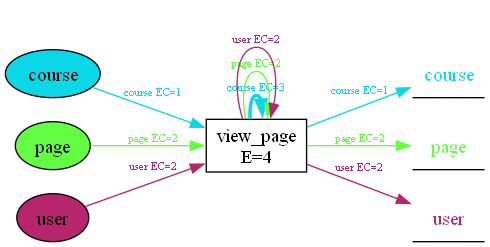

In [7]:
# We start with investigating if the question can be supprted by exploring how users view pages in the course
ets = ['view_page']
ocel_q1 = filter_ocel(ocel, course_id, ets)
ocdfg_q1 = pm4py.discover_ocdfg(ocel_q1)
pm4py.view_ocdfg(ocdfg_q1, annotation='frequency', format='png')

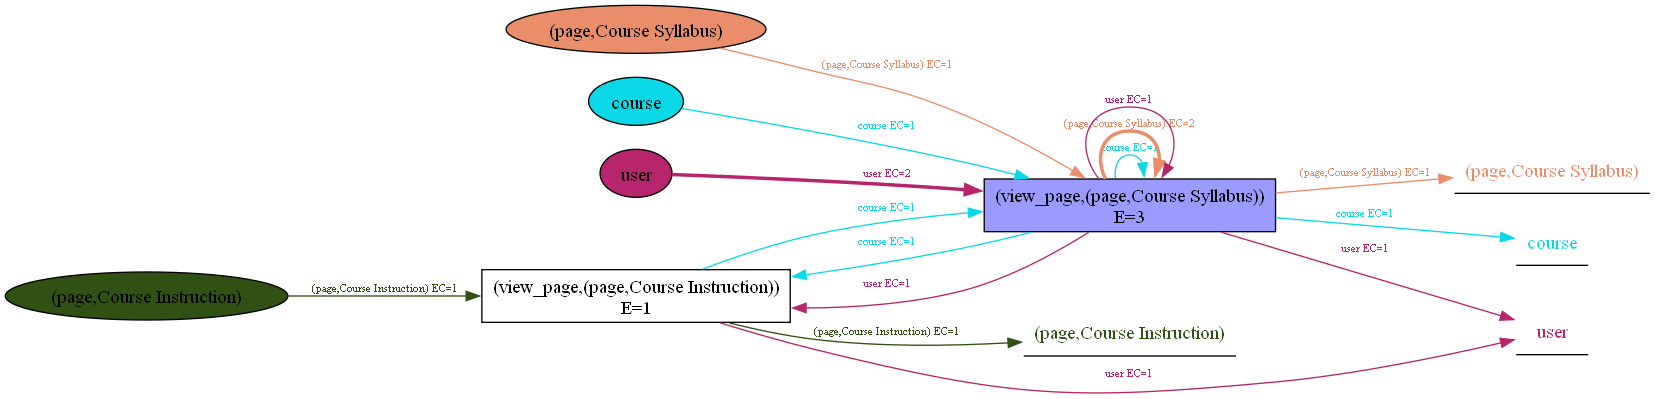

In [8]:
# The previous diagram did not reveal any significant patterns, so we will drill down to the page objects and unfold the events
# to see the relations between the page views and the users
# The resulting diagram will show how the users interact with the pages in the course
ot = "page"
transformed_ocel = ocelhelper.drill_down(ocel_q1, ot, "name")

drilled_ots = [a for a in list(transformed_ocel.objects['ocel:type'].drop_duplicates()) if a.startswith('(' + ot)]   

unfolded_ocel = transformed_ocel
for ot in drilled_ots:
    for et in ets:
        unfolded_ocel = ocelhelper.unfold(unfolded_ocel, et, ot)

pm4py.view_ocdfg(
   pm4py.discover_ocdfg(unfolded_ocel), annotation="frequency", format="png"
)

#### Q2: How do students submit (or resubmit) individual and group assignments during the course?

In [9]:
# To answer the question, we will filter the OCEL based on the submit and resubmit events for assignments
# and the set grade event, which is used to set the final grade for the assignment 
ets = ['submit_assign', 'resubmit_assign', 'set_grade']
ots = ['assign', 'user']
ots_exc = ['forum']
ocel_q2 = filter_ocel(ocel, course_id, ets, ots, ots_exc)

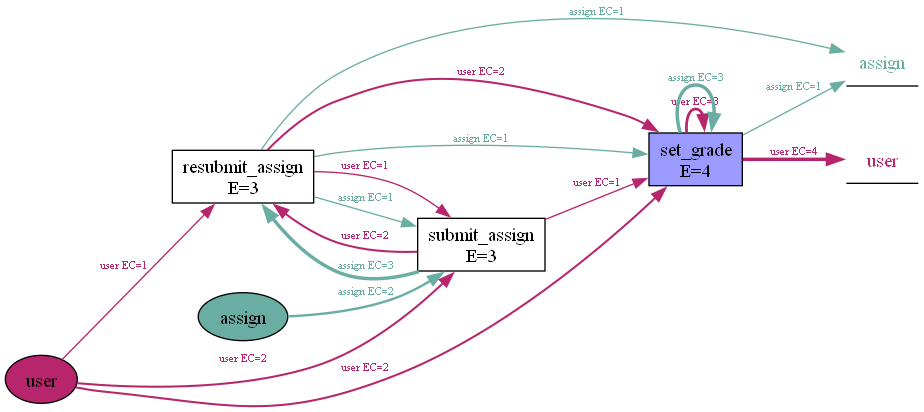

In [10]:
ocdfg_q2 = pm4py.discover_ocdfg(ocel_q2)
pm4py.view_ocdfg(ocdfg_q2, annotation='frequency', format='png')

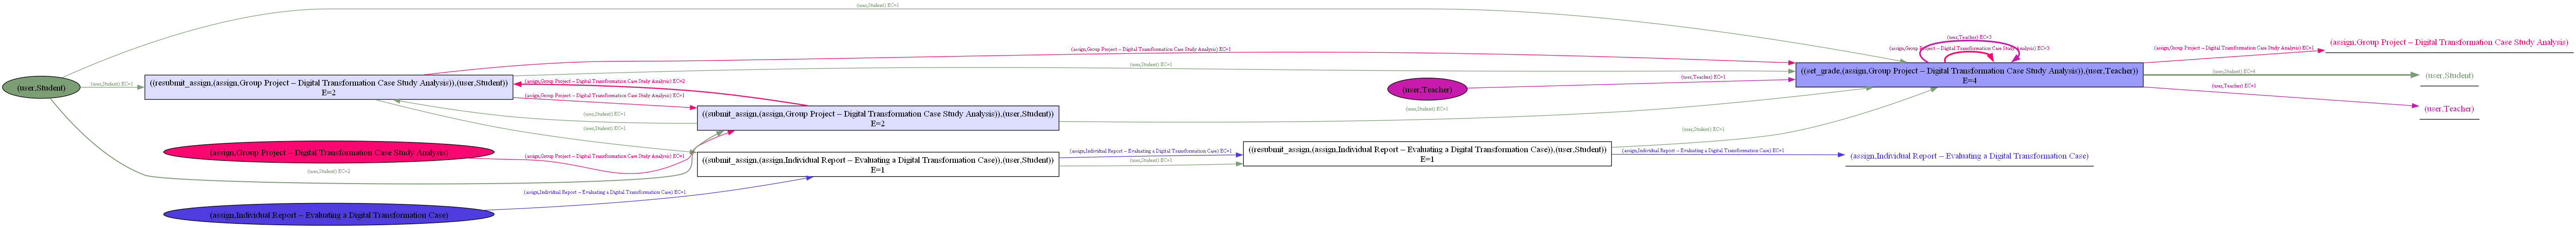

In [11]:
# The previous diagram did not reveal any significant patterns, so we will drill down to the assignment as well as user objects and unfold the events
# to see the relations between the assignment submissions and the users

ot = "assign"
transformed_ocel = ocelhelper.drill_down(ocel_q2, ot, "name")

drilled_ots = [a for a in list(transformed_ocel.objects['ocel:type'].drop_duplicates()) if a.startswith('(' + ot)]   

for ot in drilled_ots:
    for et in ets:
        transformed_ocel = ocelhelper.unfold(transformed_ocel, et, ot)

ot = "user"
transformed_ocel = ocelhelper.drill_down(transformed_ocel, ot, "user type")

drilled_ots = [a for a in list(transformed_ocel.objects['ocel:type'].drop_duplicates()) if a.startswith('(' + ot)]   

ets = list(transformed_ocel.events['ocel:activity'].unique())

for ot in drilled_ots:
    for et in ets:
        transformed_ocel = ocelhelper.unfold(transformed_ocel, et, ot)

pm4py.view_ocdfg(
   pm4py.discover_ocdfg(transformed_ocel), annotation="frequency", format="png"
)

#### Q3: Do students who usually take the lead in submitting group assignments on behalf of the group tend to achieve higher final grades?

In [12]:
# To answer the question, we will filter the OCEL based on the submit and resubmit events for assignments
# and the set grade event, which is used to set the final grade for the assignment
# We will also include the group object type to see if there are any patterns related to groups
ets = ['submit_assign', 'resubmit_assign', 'set_grade']
ots = ['assign', 'user', 'group']
ots_exc = ['forum']
ocel_q3 = filter_ocel(ocel, course_id, ets, ots, ots_exc)

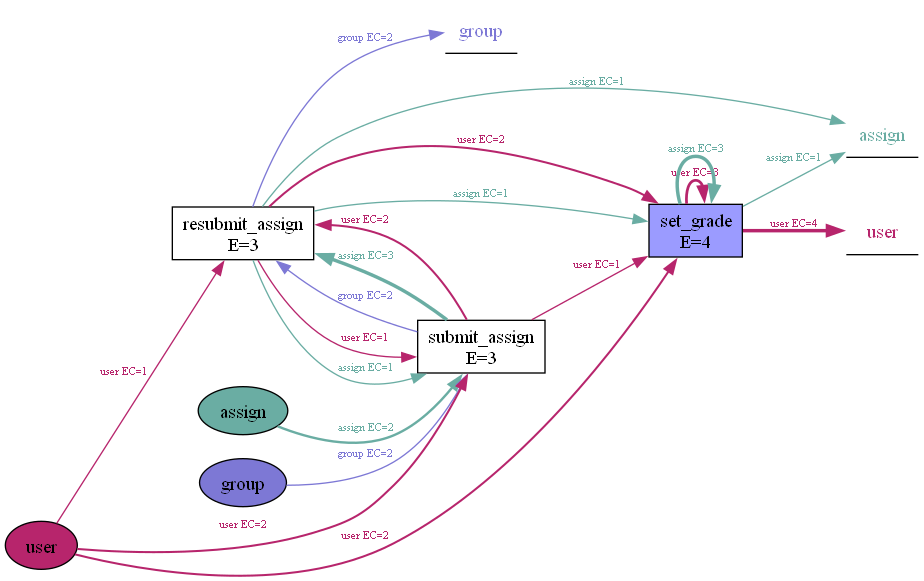

In [13]:
# The data based on this process data can be mapped to tabular form to support further analysis
ocdfg_q3 = pm4py.discover_ocdfg(ocel_q3)
pm4py.view_ocdfg(ocdfg_q3, annotation='frequency', format='png')

#### Q4: How is students' exam success related to their frequency of accessing course materials, such as files, pages, and folders?

In [14]:
# This question is about frequency of visiting files, pages, and folders in the course
# We will filter the OCEL based on the view_page, view_file, and view_folder   
ets = ['view_page', 'view_file', 'view_folder']
ocel_q4 = filter_ocel(ocel, course_id, ets)

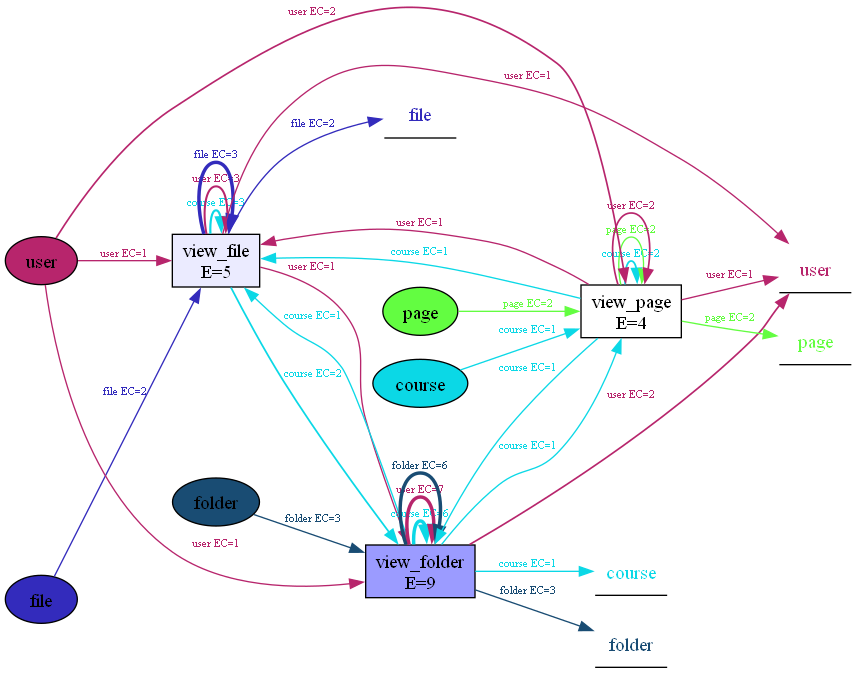

In [15]:
# The frequency of visiting files, pages, and folders in the course can be visualized using an OCDFG
# We can compile a tabular representation of the data to support further analysis
ocdfg_q4 = pm4py.discover_ocdfg(ocel_q4)
pm4py.view_ocdfg(ocdfg_q4, annotation='frequency', format='png')